In [2]:
!pip install gdown
!pip install opencv-python tensorflow numpy pandas scikit-learn matplotlib rasterio





In [3]:
# Import des librairies nécessaires
import os
import gdown
from glob import glob
import zipfile
import shutil
import tempfile
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.preprocessing.image import load_img, img_to_array
import cv2
from tqdm import tqdm
import rasterio
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader, random_split
import torchvision.transforms as transforms



In [4]:



BASE_URL = 'https://drive.google.com/uc?id={}'
BASE_PATH = os.path.abspath("C:/content")  
COMPRESSED_DIR = os.path.join(BASE_PATH, "compressed")

REGIONS = {
    'South_America': '1hnBUmYkvFYohTf9hTnKiyp2MXVevglK7',
    'Oceania': '1xHYTICHKU0u3-kIrq-pM9k0YaeQt60Bt',
    'North_America1': '1BXRGldTdGGNeWDOFqNnmiNPuPQjweB2M',
    'North_America2': '1zW_pEIggJ5Li7uQX9XKMfHkcgL3kiUoi',
    'Africa': '1Ng3JwsjJPApshk8lJdGcsNHI52NaEMDX',
    'Europe': '1vANGtfuEdn0ZnILA6BYXW1_7jt8CU0gA',
    'Asia1': '1xgOQkeQIswq3hLBhNzuNPTtsL4ZavuC3',
    'Asia2': '1w_wv0_QZhnH9jO1ygJg6ssTrXupIbTHp',
    'Asia3': '1heefSuPsnLZkNSJ2jTa4M-jGWo_9nAri',
    'Asia4': '1lyR6y6u8tSozfv3AQJ1PuUcdR0BU9yUk',
    'Asia5': '1Y1UysFrZ8AiugKvDpWI3nHcjo7-CQ4Dp',
}

SUBSET_SAMPLES = {
    'samples': '1gwQdhXrxCybcO16vem09DfW5fPadAA_p',
}

def download_file(file_id, output):
    """Télécharge un fichier Google Drive par ID."""
    url = BASE_URL.format(file_id)
    print(f"⬇️ Téléchargement depuis Google Drive : {output}")
    gdown.download(url, output, quiet=False, fuzzy=True)

def download_regions(region_list, output_dir=COMPRESSED_DIR, subset=False):
    """
    Télécharge les datasets spécifiés.

    Args:
        region_list (list): Liste des régions à télécharger (ex: ["Asia2", "Asia3"])
        output_dir (str): Dossier de sortie
        subset (bool): Si True, télécharge uniquement le subset samples.zip
    """
    os.makedirs(output_dir, exist_ok=True)

    if subset:
        # Téléchargement du subset
        zip_file_name = 'samples.zip'
        output = os.path.join(BASE_PATH, zip_file_name)
        print("⬇️ Téléchargement du subset d'échantillons...")
        download_file(SUBSET_SAMPLES['samples'], output)
        return output

    else:
        downloaded_files = []
        for region in region_list:
            if region not in REGIONS:
                print(f"⚠️ Région {region} inconnue. Ignorée.")
                continue

            zip_file_name = f'{region}.zip'
            output = os.path.join(output_dir, zip_file_name)
            print(f"=== Téléchargement de la région : {region} ===")
            download_file(REGIONS[region], output)
            downloaded_files.append(output)
        return downloaded_files


In [5]:


# Chemin de base pour Windows/Linux (adapte si besoin)
BASE_PATH = os.path.abspath("C:/content")
COMPRESSED_DIR = os.path.join(BASE_PATH, "compressed")
IMAGES_DIR = os.path.join(BASE_PATH, "images")
MASKS_DIR = os.path.join(BASE_PATH, "masks")

def unzip_dataset(full_dataset=True,
                  samples_zip_path=os.path.join(BASE_PATH, "samples.zip"),
                  compressed_dir=COMPRESSED_DIR,
                  output_dir=BASE_PATH):
    """
    Décompresse soit le full dataset (compressed/*.zip), soit le subset (samples.zip).

    Args:
        full_dataset (bool): Si True -> décompresse le dataset complet, sinon subset.
        samples_zip_path (str): chemin vers le fichier samples.zip
        compressed_dir (str): chemin vers les zips continents téléchargés
        output_dir (str): dossier de sortie final
    """
    if full_dataset:
        print('Unzipping Full Dataset...')

        # Création des répertoires fixes
        patches_output_dir = os.path.join(IMAGES_DIR, 'patches')
        masks_output_dir = os.path.join(MASKS_DIR, 'patches')
        voting_output_dir = os.path.join(MASKS_DIR, 'voting')
        intersection_output_dir = os.path.join(MASKS_DIR, 'intersection')

        for d in [patches_output_dir, masks_output_dir, voting_output_dir, intersection_output_dir]:
            os.makedirs(d, exist_ok=True)

        zips_continents = glob(os.path.join(compressed_dir, '*.zip'))

        tmp_dir = os.path.join(output_dir, 'tmp')
        tmp_derivates = os.path.join(output_dir, 'tmp_derivates')

        print(f'Unzip images to {patches_output_dir}')
        print(f'Unzip masks to {masks_output_dir}')

        total_files = 0
        for zip_continent in zips_continents:
            print(f'Unzipping: {zip_continent}')

            os.makedirs(tmp_dir, exist_ok=True)

            with zipfile.ZipFile(zip_continent, 'r') as zip_ref:
                print(f'Num zipped files: {len(zip_ref.namelist())}')
                zip_ref.extractall(tmp_dir)

            patches_zips = glob(os.path.join(tmp_dir, '*.zip'))
            print(f'Num. of zips unpacked: {len(patches_zips)}')

            print('Unzipping patches...')
            num_files = 0
            for patches_zip in patches_zips:
                output_dir_zip = patches_output_dir

                if patches_zip.endswith('masks_derivates.zip'):
                    with zipfile.ZipFile(patches_zip, 'r') as zip_ref:
                        zip_ref.extractall(tmp_derivates)
                        num_files += len(zip_ref.namelist())

                    derivate_patches = glob(os.path.join(tmp_derivates, '*.tif'))

                    for derivate_patch in derivate_patches:
                        if '_voting_' in derivate_patch.lower():
                            shutil.move(derivate_patch, derivate_patch.replace(tmp_derivates, voting_output_dir))
                        elif '_intersection_' in derivate_patch.lower():
                            shutil.move(derivate_patch, derivate_patch.replace(tmp_derivates, intersection_output_dir))

                    shutil.rmtree(tmp_derivates)
                    continue

                if patches_zip.endswith('masks.zip'):
                    output_dir_zip = masks_output_dir

                with zipfile.ZipFile(patches_zip, 'r') as zip_ref:
                    zip_ref.extractall(output_dir_zip)
                    num_files += len(zip_ref.namelist())

            total_files += num_files
            print(f'Zip: {zip_continent} - Patches: {num_files}')
            shutil.rmtree(tmp_dir)

        print(f'Total files unzipped: {total_files}')
        print('✅ Full Dataset Ready!')

    else:
        print("Unzipping subset samples...")
        with tempfile.TemporaryDirectory() as tmpdirname:
            with zipfile.ZipFile(samples_zip_path, 'r') as zip_ref:
                zip_ref.extractall(tmpdirname)

            images_path = IMAGES_DIR
            masks_path = MASKS_DIR
            manual_annotations_path = os.path.join(BASE_PATH, 'manual_annotations', 'patches')

            for d in [images_path, masks_path, manual_annotations_path]:
                os.makedirs(d, exist_ok=True)

            image_zip = os.path.join(tmpdirname, 'samples', 'images', 'patches.zip')
            with zipfile.ZipFile(image_zip, 'r') as zip_ref:
                zip_ref.extractall(images_path)

            masks_zips = glob(os.path.join(tmpdirname, 'samples', 'masks', '*.zip'))
            for mask_zip in masks_zips:
                with zipfile.ZipFile(mask_zip, 'r') as zip_ref:
                    zip_ref.extractall(masks_path)

            masks = glob(os.path.join(masks_path, 'patches', '*_GOLI_v2_*.tif'))
            for mask in masks:
                mask_name = os.path.basename(mask)
                os.rename(
                    os.path.join(masks_path, 'patches', mask_name),
                    os.path.join(masks_path, 'patches', mask_name.replace('GOLI_v2', 'Kumar-Roy'))
                )

            manual_annotations_zips = glob(os.path.join(tmpdirname, 'samples', 'manual_annotations', '*.zip'))
            for manual_ann_zip in manual_annotations_zips:
                with zipfile.ZipFile(manual_ann_zip, 'r') as zip_ref:
                    zip_ref.extractall(manual_annotations_path)

        print("✅ Subset unzipped successfully.")


In [6]:
"""
Retourne 2 listes :
- images_list : chemins des images avec au moins NUM_PIXELS de feu
- masks_list  : chemins des masques correspondants
"""


# === Adapte ici ===
MASK_PATH = r"C:/content/masks"
IMAGE_PATH = r"C:/content/images"
MASK_ALGORITHM = "Kumar-Roy"  # adapte si besoin
NUM_PIXELS = 20


def get_mask_arr(path):
    """Charge un masque en array numpy"""
    with rasterio.open(path) as src:
        img = src.read().transpose((1, 2, 0))
        seg = np.array(img, dtype=int)
        return seg[:, :, 0]


def find_fire_images_and_masks(mask_path=MASK_PATH, image_path=IMAGE_PATH,
                               num_pixels=NUM_PIXELS, algo=MASK_ALGORITHM):
    """
    Retourne deux listes :
    - images_list
    - masks_list
    contenant uniquement les chemins correspondant aux masques
    avec au moins num_pixels pixels feu.
    """
    masks_files = glob(os.path.join(mask_path, f"*{algo}*.tif"))
    images_list, masks_list = [], []

    for mask_file in masks_files:
        mask = get_mask_arr(mask_file)
        count = (mask > 0).sum()

        if count > num_pixels:
            # Construire chemin image correspondant
            mask_name = os.path.basename(mask_file)
            image_name = mask_name.replace(f"_{algo}_", "_")
            image_file = os.path.join(image_path, image_name)

            if os.path.exists(image_file):  # sécurité
                images_list.append(image_file)
                masks_list.append(mask_file)

    return images_list, masks_list


In [7]:


# Normalisation max Landsat pixel value (ex: 65535 pour 16-bit)
MAX_PIXEL_VALUE = 65535.0

def get_img_762bands(path):
    img = rasterio.open(path).read((7,6,2)).transpose((1, 2, 0))
    img = np.float32(img)/MAX_PIXEL_VALUE

    return img

def get_mask_arr(path):
    img = rasterio.open(path).read().transpose((1, 2, 0))
    seg = np.float32(img)
    return seg

def load_all_images_and_masks(images_path_list, masks_path_list, size=(256, 256)):
    """Retourne X (images) et y (masques) en numpy arrays, avec barre de progression."""
    X = []
    y = []
    fopen_image = get_img_762bands
    fopen_mask = get_mask_arr

    for img_path, mask_path in tqdm(zip(images_path_list, masks_path_list),
                                    total=len(images_path_list),
                                    desc="Chargement des images et masques"):
        try:
            img = fopen_image(img_path)
            mask = fopen_mask(mask_path)
            X.append(img)
            y.append(mask)
        except Exception as e:
            print(f"[WARNING] Impossible de charger {img_path} ou {mask_path} | Erreur: {e}")

    return np.array(X), np.array(y)


In [4]:



# -----------------------------
# Double Convolution Block
# -----------------------------
class ConvBlock(nn.Module):
    def __init__(self, in_channels, out_channels):
        super().__init__()
        self.block = nn.Sequential(
            nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1, bias=False),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True),

            nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=1, bias=False),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True),
        )

    def forward(self, x):
        return self.block(x)


# -----------------------------
# Attention Gate
# -----------------------------
class AttentionGate(nn.Module):
    def __init__(self, in_channels, gating_channels, inter_channels):
        super().__init__()
        self.W_g = nn.Sequential(
            nn.Conv2d(gating_channels, inter_channels, kernel_size=1, stride=1, padding=0, bias=True),
            nn.BatchNorm2d(inter_channels)
        )

        self.W_x = nn.Sequential(
            nn.Conv2d(in_channels, inter_channels, kernel_size=1, stride=1, padding=0, bias=True),
            nn.BatchNorm2d(inter_channels)
        )

        self.psi = nn.Sequential(
            nn.Conv2d(inter_channels, 1, kernel_size=1, stride=1, padding=0, bias=True),
            nn.BatchNorm2d(1),
            nn.Sigmoid()
        )

        self.relu = nn.ReLU(inplace=True)

    def forward(self, x, g):
        g1 = self.W_g(g)
        x1 = self.W_x(x)

        psi = self.relu(g1 + x1)
        psi = self.psi(psi)

        return x * psi


# -----------------------------
# Attention U-Net
# -----------------------------
class AttentionUNet(nn.Module):
    def __init__(self, img_ch=3, output_ch=1):
        super().__init__()

        # Encoder
        self.conv1 = ConvBlock(img_ch, 64)
        self.pool1 = nn.MaxPool2d(2)

        self.conv2 = ConvBlock(64, 128)
        self.pool2 = nn.MaxPool2d(2)

        self.conv3 = ConvBlock(128, 256)
        self.pool3 = nn.MaxPool2d(2)

        self.conv4 = ConvBlock(256, 512)
        self.pool4 = nn.MaxPool2d(2)

        self.conv5 = ConvBlock(512, 1024)

        # Attention + Decoder
        self.up4 = nn.ConvTranspose2d(1024, 512, kernel_size=2, stride=2)
        self.att4 = AttentionGate(512, 512, 256)
        self.up_conv4 = ConvBlock(1024, 512)

        self.up3 = nn.ConvTranspose2d(512, 256, kernel_size=2, stride=2)
        self.att3 = AttentionGate(256, 256, 128)
        self.up_conv3 = ConvBlock(512, 256)

        self.up2 = nn.ConvTranspose2d(256, 128, kernel_size=2, stride=2)
        self.att2 = AttentionGate(128, 128, 64)
        self.up_conv2 = ConvBlock(256, 128)

        self.up1 = nn.ConvTranspose2d(128, 64, kernel_size=2, stride=2)
        self.att1 = AttentionGate(64, 64, 32)
        self.up_conv1 = ConvBlock(128, 64)

        # Final conv
        self.out_conv = nn.Conv2d(64, output_ch, kernel_size=1)

    def forward(self, x):
        # Encoder
        x1 = self.conv1(x)
        p1 = self.pool1(x1)

        x2 = self.conv2(p1)
        p2 = self.pool2(x2)

        x3 = self.conv3(p2)
        p3 = self.pool3(x3)

        x4 = self.conv4(p3)
        p4 = self.pool4(x4)

        x5 = self.conv5(p4)

        # Decoder with Attention
        d4 = self.up4(x5)
        x4 = self.att4(x4, d4)
        d4 = torch.cat((x4, d4), dim=1)
        d4 = self.up_conv4(d4)

        d3 = self.up3(d4)
        x3 = self.att3(x3, d3)
        d3 = torch.cat((x3, d3), dim=1)
        d3 = self.up_conv3(d3)

        d2 = self.up2(d3)
        x2 = self.att2(x2, d2)
        d2 = torch.cat((x2, d2), dim=1)
        d2 = self.up_conv2(d2)

        d1 = self.up1(d2)
        x1 = self.att1(x1, d1)
        d1 = torch.cat((x1, d1), dim=1)
        d1 = self.up_conv1(d1)

        out = self.out_conv(d1)
        out = F.interpolate(out, size=(256, 256), mode="bilinear", align_corners=False)
        return out


# -----------------------------
# Test
# -----------------------------
if __name__ == "__main__":
    model = AttentionUNet(img_ch=3, output_ch=1)
    inp = torch.randn(1, 3, 256, 256)
    out = model(inp)
    print("Input:", inp.shape)
    print("Output:", out.shape)  # (1, 1, 256, 256)


Input: torch.Size([1, 3, 256, 256])
Output: torch.Size([1, 1, 256, 256])


In [9]:



# -----------------------------
# Nettoyer le GPU 
# -----------------------------
torch.cuda.empty_cache()


# -----------------------------
# Créer le modèle
# -----------------------------
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = AttentionUNet(img_ch=3, output_ch=1).to(device)
device


device(type='cuda')

In [10]:


# -----------------------------
# Dice Loss (pour segmentation binaire)
# -----------------------------
class DiceLoss(nn.Module):
    def __init__(self, smooth=1.0):
        super().__init__()
        self.smooth = smooth

    def forward(self, y_pred, y_true):
        y_pred = torch.sigmoid(y_pred)
        y_true_f = y_true.view(-1)
        y_pred_f = y_pred.view(-1)
        intersection = (y_true_f * y_pred_f).sum()
        dice = (2. * intersection + self.smooth) / (y_true_f.sum() + y_pred_f.sum() + self.smooth)
        return 1 - dice   # On retourne la loss, donc 1 - Dice
        

# -----------------------------
# Focal Loss
# -----------------------------
class FocalLoss(nn.Module):
    def __init__(self, gamma=2., alpha=0.25, reduction='mean'):
        super().__init__()
        self.gamma = gamma
        self.alpha = alpha
        self.reduction = reduction

    def forward(self, y_pred, y_true):
        y_pred = torch.sigmoid(y_pred)
        y_pred = y_pred.clamp(1e-7, 1 - 1e-7)

        bce = - (y_true * torch.log(y_pred) + (1 - y_true) * torch.log(1 - y_pred))
        pt = torch.where(y_true == 1, y_pred, 1 - y_pred)
        focal_term = self.alpha * (1 - pt) ** self.gamma
        loss = focal_term * bce

        if self.reduction == 'mean':
            return loss.mean()
        elif self.reduction == 'sum':
            return loss.sum()
        else:
            return loss


# -----------------------------
# Combined Loss : Focal + Dice
# -----------------------------
class FocalDiceLoss(nn.Module):
    def __init__(self, alpha=0.5, gamma=2., lambda_dice=1.0, lambda_focal=1.0):
        super().__init__()
        self.focal = FocalLoss(gamma=gamma, alpha=alpha)
        self.dice = DiceLoss()
        self.lambda_dice = lambda_dice
        self.lambda_focal = lambda_focal

    def forward(self, y_pred, y_true):
        loss_focal = self.focal(y_pred, y_true)
        loss_dice = self.dice(y_pred, y_true)
        return self.lambda_focal * loss_focal + self.lambda_dice * loss_dice


# -----------------------------
# Exemple d’utilisation
# -----------------------------
criterion = FocalDiceLoss(alpha=0.75, gamma=2., lambda_dice=1.0, lambda_focal=1.0)

y_true = torch.randint(0, 2, (8, 1, 256, 256), dtype=torch.float32)
y_pred = torch.rand(8, 1, 256, 256)

loss = criterion(y_pred, y_true)
print("Combined Focal + Dice Loss:", loss.item())


Combined Focal + Dice Loss: 0.6233306527137756


In [11]:


def cleanup_dataset(
    image_path='images/patches',
    mask_path='masks/patches',
    compressed_path='compressed'
):
    """
    Supprime tous les fichiers contenus dans :
    - images/patches
    - masks/patches
    - compressed
    
    Et recrée les dossiers vides pour éviter les erreurs plus tard.
    """
    removed = 0
    for folder in [image_path, mask_path, compressed_path]:
        if os.path.exists(folder):
            for f in os.listdir(folder):
                file_path = os.path.join(folder, f)
                try:
                    if os.path.isfile(file_path):
                        os.remove(file_path)
                        removed += 1
                    elif os.path.isdir(file_path):
                        shutil.rmtree(file_path)
                        removed += 1
                except Exception as e:
                    print(f"❌ Impossible de supprimer {file_path} : {e}")
        else:
            os.makedirs(folder, exist_ok=True)

    print(f"✅ Cleanup terminé. {removed} fichiers supprimés.")


In [12]:



EPOCHS = 10
BATCH_SIZE = 8

# -----------------------------
# Dataset personnalisé
# -----------------------------
class FireDataset(Dataset):
    def __init__(self, images, masks, transform=None):
        self.images = images
        self.masks = masks
        self.transform = transform

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        img = self.images[idx]
        mask = self.masks[idx]
        if self.transform:
            img = self.transform(img)
            mask = self.transform(mask)
        return img.float(), mask.float()


# -----------------------------
# Dice coefficient (métrique)
# -----------------------------
def dice_coef(y_true, y_pred, smooth=1.0):
    y_pred = (torch.sigmoid(y_pred) > 0.5).float()  # binarisation
    y_true_f = y_true.view(-1)
    y_pred_f = y_pred.view(-1)
    intersection = (y_true_f * y_pred_f).sum()
    return (2. * intersection + smooth) / (y_true_f.sum() + y_pred_f.sum() + smooth)


# -----------------------------
# Boucle principale
# -----------------------------
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

# 👉 Ici on utilise ta loss définie ailleurs
criterion = FocalDiceLoss(alpha=0.75, gamma=2., lambda_dice=1.0, lambda_focal=1.0)
optimizer = optim.Adam(model.parameters(), lr=1e-3)

transform = transforms.Compose([
    transforms.ToTensor(),
])

# Régions à traiter
regions = [
    "South_America", 

    #"Asia2", "Asia3", "Asia4", 
    #"North_America1", "North_America2"
]
cleanup_dataset(
        image_path="c:/content/images/patches",
        mask_path="c:/content/masks/patches",
        compressed_path="c:/content/compressed"
    )

for region in regions:
    print(f"\n === Traitement de {region} ===")

    # 1. Télécharger dataset
    download_regions([region], output_dir="c:/content/compressed")
    unzip_dataset(full_dataset=True,
                 compressed_dir="c:/content/compressed",
                
                 output_dir="c:/content")

    # 2. Filtrer images/masks
    image_paths, masks_paths = find_fire_images_and_masks(
        image_path="c:/content/images/patches",
        mask_path="c:/content/masks/patches"
    )
    X, y = load_all_images_and_masks(image_paths, masks_paths, size=(256, 256))

    # Créer dataset
    dataset = FireDataset(X, y, transform=transform)

    # Split train/test
    test_size = int(0.05 * len(dataset))
    train_size = len(dataset) - test_size
    train_dataset, test_dataset = random_split(dataset, [train_size, test_size])

    train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
    test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False)

    # 3. Entraîner modèle
    model.to(device)
    model.train()
    for epoch in range(EPOCHS):
        running_loss = 0.0
        running_dice = 0.0
        for imgs, masks in train_loader:
            imgs, masks = imgs.to(device), masks.to(device)

            optimizer.zero_grad()
            outputs = model(imgs)
            loss = criterion(outputs, masks)
            loss.backward()
            optimizer.step()
           
            running_loss += loss.item()
            

            # --- Calcul du Dice ---
            dice = dice_coef(masks, outputs)
            running_dice += dice.item()

        avg_loss = running_loss / len(train_loader)
        avg_dice = running_dice / len(train_loader)

        print(f"Epoch {epoch+1}/{EPOCHS}, Loss: {avg_loss:.4f}, Dice: {avg_dice:.4f}")

    # 4. Supprimer dataset pour libérer RAM/disque
    del dataset, train_loader, X, y
    torch.cuda.empty_cache()
    cleanup_dataset(
        image_path="c:/content/images/patches",
        mask_path="c:/content/masks/patches",
        compressed_path="c:/content/compressed"
    )


Using device: cuda
✅ Cleanup terminé. 400 fichiers supprimés.

 === Traitement de South_America ===
=== Téléchargement de la région : South_America ===
⬇️ Téléchargement depuis Google Drive : c:/content/compressed\South_America.zip


Downloading...
From (original): https://drive.google.com/uc?id=1hnBUmYkvFYohTf9hTnKiyp2MXVevglK7
From (redirected): https://drive.google.com/uc?id=1hnBUmYkvFYohTf9hTnKiyp2MXVevglK7&confirm=t&uuid=147ecaf1-5a7e-4bb5-a0c7-7bde89d61c31
To: c:\content\compressed\South_America.zip
100%|█████████████████████████████████████████████████████████████████████████████| 13.6G/13.6G [28:16<00:00, 8.02MB/s]


Unzipping Full Dataset...
Unzip images to C:\content\images\patches
Unzip masks to C:\content\masks\patches
Unzipping: c:/content/compressed\South_America.zip
Num zipped files: 896
Num. of zips unpacked: 896
Unzipping patches...
Zip: c:/content/compressed\South_America.zip - Patches: 51404
Total files unzipped: 51404
✅ Full Dataset Ready!


Chargement des images et masques: 100%|██████████████████████████████████████████████| 738/738 [00:36<00:00, 20.35it/s]


Epoch 1/5, Loss: 1.0072, Dice: 0.5482
Epoch 2/5, Loss: 0.9629, Dice: 0.6603
Epoch 3/5, Loss: 0.4134, Dice: 0.8173
Epoch 4/5, Loss: 0.1293, Dice: 0.8877
Epoch 5/5, Loss: 0.1171, Dice: 0.8935
✅ Cleanup terminé. 37626 fichiers supprimés.


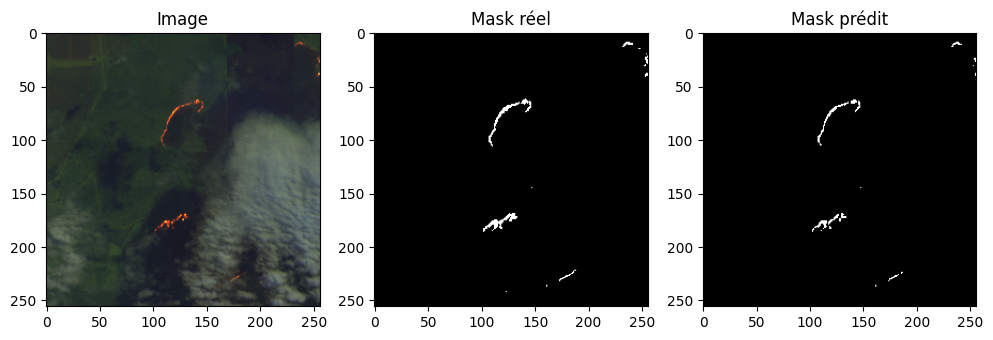

In [14]:


# === 5. Tester le modèle sur un batch ===
model.to(device)
model.eval()

with torch.no_grad():
    images, masks = next(iter(test_loader))
    images, masks = images.to(device), masks.to(device)

    outputs = model(images)
    preds = torch.sigmoid(outputs) > 0.5

# === 6. Affichage ===
idx = np.random.randint(0, images.shape[0])

plt.figure(figsize=(12, 4))
plt.subplot(1, 3, 1)
plt.title("Image")
plt.imshow(images[idx].cpu().permute(1, 2, 0)[..., :3])  # 3 canaux

plt.subplot(1, 3, 2)
plt.title("Mask réel")
plt.imshow(masks[idx].cpu().squeeze(), cmap="gray")

plt.subplot(1, 3, 3)
plt.title("Mask prédit")
plt.imshow(preds[idx].cpu().squeeze(), cmap="gray")
plt.show()


In [17]:
# === 1. Télécharger le subset sample ===
samples_zip = download_regions(region_list=None, subset=True, output_dir=COMPRESSED_DIR)

# === 2. Dézipper ===
unzip_dataset(full_dataset=False, samples_zip_path=samples_zip)

 #=== 3. Charger images + masques filtrés ===
image_paths, mask_paths = find_fire_images_and_masks(
    image_path=os.path.join(IMAGES_DIR, "patches"),
    mask_path=os.path.join(MASKS_DIR, "patches"),
    num_pixels=10)

print(f"Images trouvées: {len(image_paths)}")
print(f"Masks trouvés: {len(mask_paths)}")
X, y = load_all_images_and_masks(image_paths, mask_paths, size=(256, 256))
dataset = FireDataset(X, y, transform=transform)
test_size = int(0.95 * len(dataset))
train_size = len(dataset) - test_size
train_dataset, test_dataset = random_split(dataset, [train_size, test_size])
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False)


⬇️ Téléchargement du subset d'échantillons...
⬇️ Téléchargement depuis Google Drive : C:\content\samples.zip


Downloading...
From (original): https://drive.google.com/uc?id=1gwQdhXrxCybcO16vem09DfW5fPadAA_p
From (redirected): https://drive.google.com/uc?id=1gwQdhXrxCybcO16vem09DfW5fPadAA_p&confirm=t&uuid=252921c9-a220-44c4-ae76-9da70c60cbf3
To: C:\content\samples.zip
100%|███████████████████████████████████████████████████████████████████████████████| 242M/242M [00:04<00:00, 53.5MB/s]


Unzipping subset samples...
✅ Subset unzipped successfully.
Images trouvées: 34
Masks trouvés: 34


Chargement des images et masques: 100%|████████████████████████████████████████████████| 34/34 [00:01<00:00, 18.15it/s]


In [6]:
# Évaluation du modèle sur le test_loader
def evaluate_model(model, test_loader, device):
    model.eval()
    total_dice = 0.0
    total_loss = 0.0
    criterion = FocalDiceLoss(alpha=0.75, gamma=2., lambda_dice=1.0, lambda_focal=1.0) # même loss qu'à l'entraînement
    
    with torch.no_grad():
        for images, masks in test_loader:
            images, masks = images.to(device), masks.to(device)
            
            # Forward
            outputs = model(images)
            loss = criterion(outputs, masks)
            
            # Activation sigmoid
            outputs = torch.sigmoid(outputs)
            
            # Dice score
            dice = dice_coef(outputs, masks)
            
            total_loss += loss.item()
            total_dice += dice
    
    avg_loss = total_loss / len(test_loader)
    avg_dice = total_dice / len(test_loader)
    
    print(f"Test Loss: {avg_loss:.4f}")
    print(f"Test Dice Coefficient: {avg_dice:.4f}")
    return avg_loss, avg_dice

evaluate_model(model, test_loader, device)

NameError: name 'test_loader' is not defined

In [1]:
save_path = "attention_unet_weights.pth"
torch.save(model.state_dict(), save_path)
print(f"Modèle sauvegardé dans {save_path}")

NameError: name 'torch' is not defined